<a href="https://colab.research.google.com/github/Bryan-Az/TimeGPT-Tabula9-RDL/blob/main/TimeGPT/TimeGPT_Forecasting_AnomalyDetect_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TimeGPT: Long Horizon Forecasting, Anomaly Detection, and Fine-tuning

TimeGPT is a 'foundational' neural network model trained to predict using multivarate timeseries data. As it is a 'foundational' model, it is typically accessed using their API as the model is trained by the company 'Nixtla'. As the model is large and pre-trained, it performs fairly well using 'zero-shot' or 'few-shot' input prompting (none or not that many examples/data given for fine-tuning), depending on the data used and the task.

## Imports and Installs
Nixtla is the provider of the TimeGPT model and has their own pip package that can be used to make calls to TimeGPT's API. Since it is not loading the model directly into the environment an [API key from Nixtla](https://dashboard.nixtla.io/sign_in) is required.

In [ ]:
%%capture
!pip install nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from nixtla import NixtlaClient
from google.colab import userdata

In [ ]:
nixtla_client = NixtlaClient(
    api_key = userdata.get('nixtla')
)

## Data Loading and Transformation

### What kind of Data?

Nixtla provides example [datasets](https://https://github.com/Nixtla/transfer-learning-time-series) for use with their model. I'll be using their 'electricity.csv' and 'bitcoin_price_usd.csv' datasets.

### What kind of prediction or forecasting task?
Nixtla has 2 models: time-gpt-1 trained for prediction of shorter time-frames (e.i if hourly data, a day of prediction), and timegpt-1-long-horizon meant for 'long horizons' (e.i if hourly data, ~3 days of prediction). Since I'll be using a mix of datasets that have been constructed using shorter and larger time-frames, I'll be using both of Nixtla's models.

## Long Horizon Forecasting

### Multi-variate Short Horizon Energy Price Forecasting
Since the energy pricing information was collected on an hourly time-frame, forecasting up to a couple days requires the long-horizon model to reduce the amount of uncertainty in the predictions. Time-GPT can make better predictions when the forecast length fits the model's time-frame (for hourly data this is typically only 24 hours).

In [12]:
electricity = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity.csv')
print(electricity.shape)
print('Earliest date: ', electricity.ds.min())
print('Latest date: ', electricity.ds.max())
electricity.head()

(261960, 3)
Earliest date:  2011-01-09 00:00:00
Latest date:  2018-12-23 23:00:00


,unique_id,ds,y
0,BE,2011-01-09 00:00:00,32.54
1,BE,2011-01-09 01:00:00,21.55
2,BE,2011-01-09 02:00:00,15.71
3,BE,2011-01-09 03:00:00,10.58
4,BE,2011-01-09 04:00:00,10.32


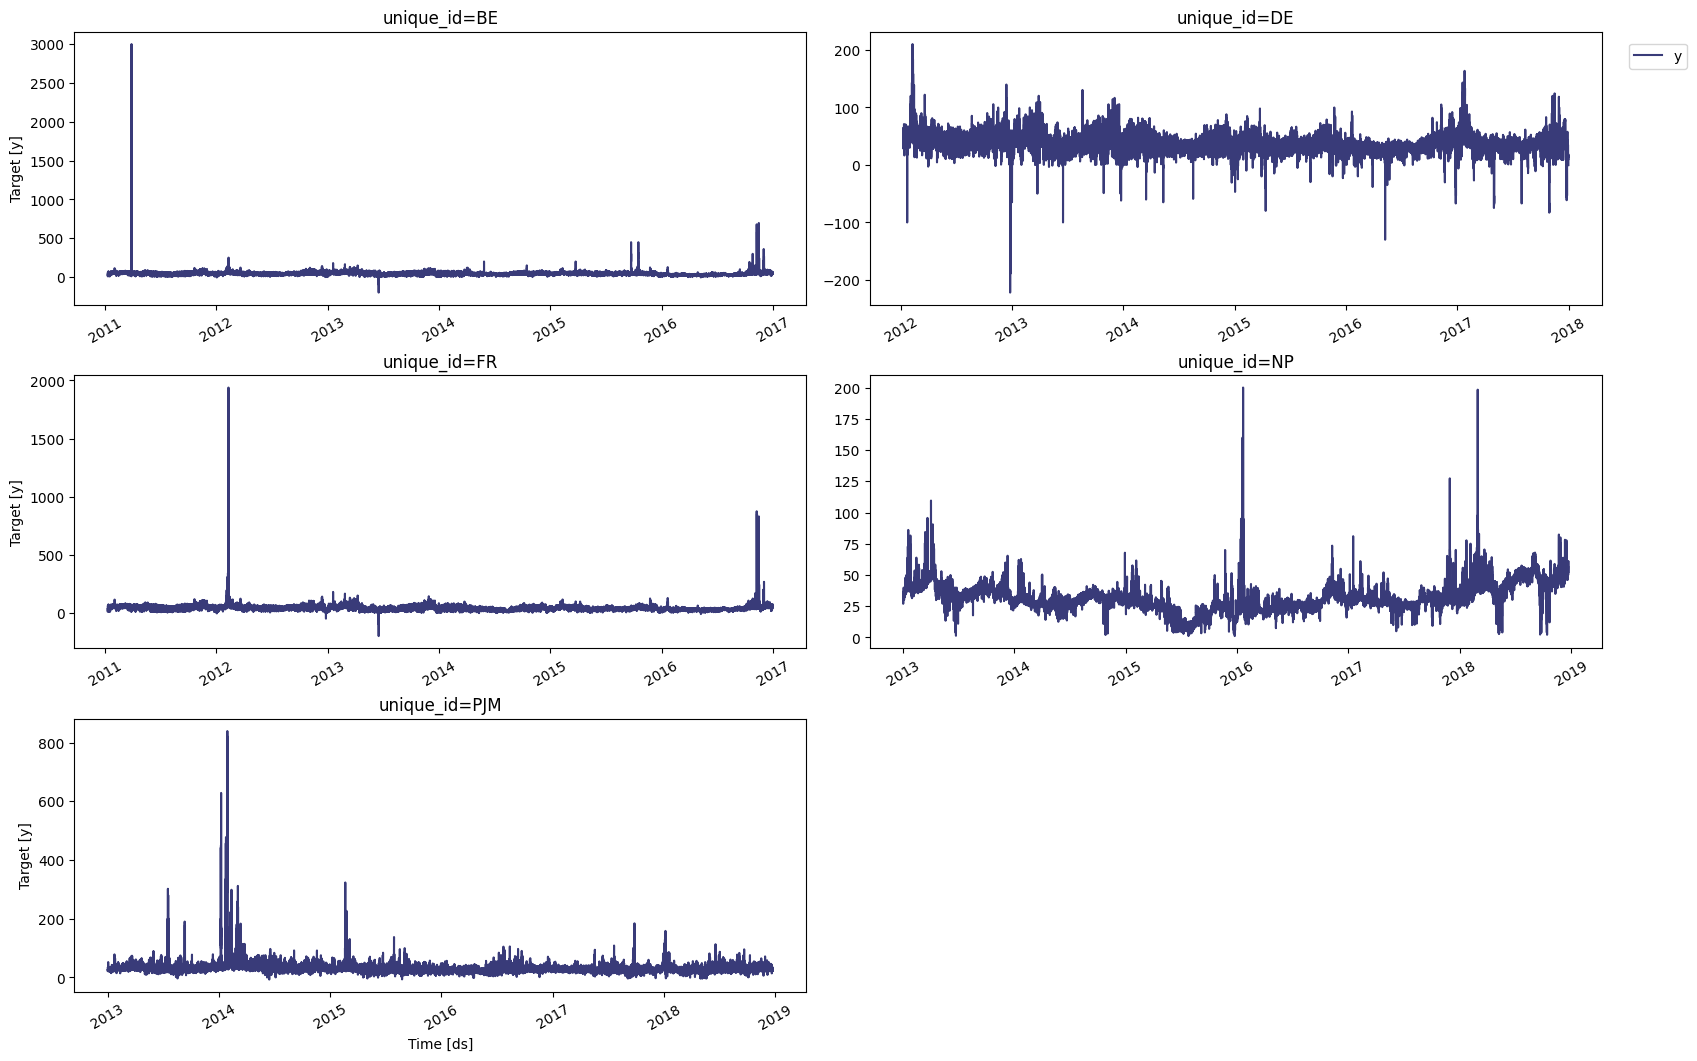

In [15]:
# nixtla client's plot method requires the feature names to be formatted with unique_id, ds (i.e the datetime), and y (i.e the value)
nixtla_client.plot(electricity)

In [25]:
# forecasting horizon h = 1 day (24 hours) for all time-series at once without fine-tuning
multivariate_forecast = nixtla_client.forecast(df=electricity, h=24, level=[80, 90])
multivariate_forecast.head()

,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-12-31 00:00:00,45.190453,54.872482,57.369510,35.508423,33.011395
1,BE,2016-12-31 01:00:00,43.244446,51.114265,56.101627,35.374626,30.387266
2,BE,2016-12-31 02:00:00,41.958390,48.575985,54.632984,35.340794,29.283792
3,BE,2016-12-31 03:00:00,39.796486,47.266720,49.682045,32.326252,29.910927
4,BE,2016-12-31 04:00:00,39.204536,47.410120,47.677834,30.998955,30.731240


The nixtla client's plot method is able to visualize the output of the forecast and includes the confidence interval as a range (TimeGPT_level_80 and level_90). The red line is the prediction and the blue-line is the original data.

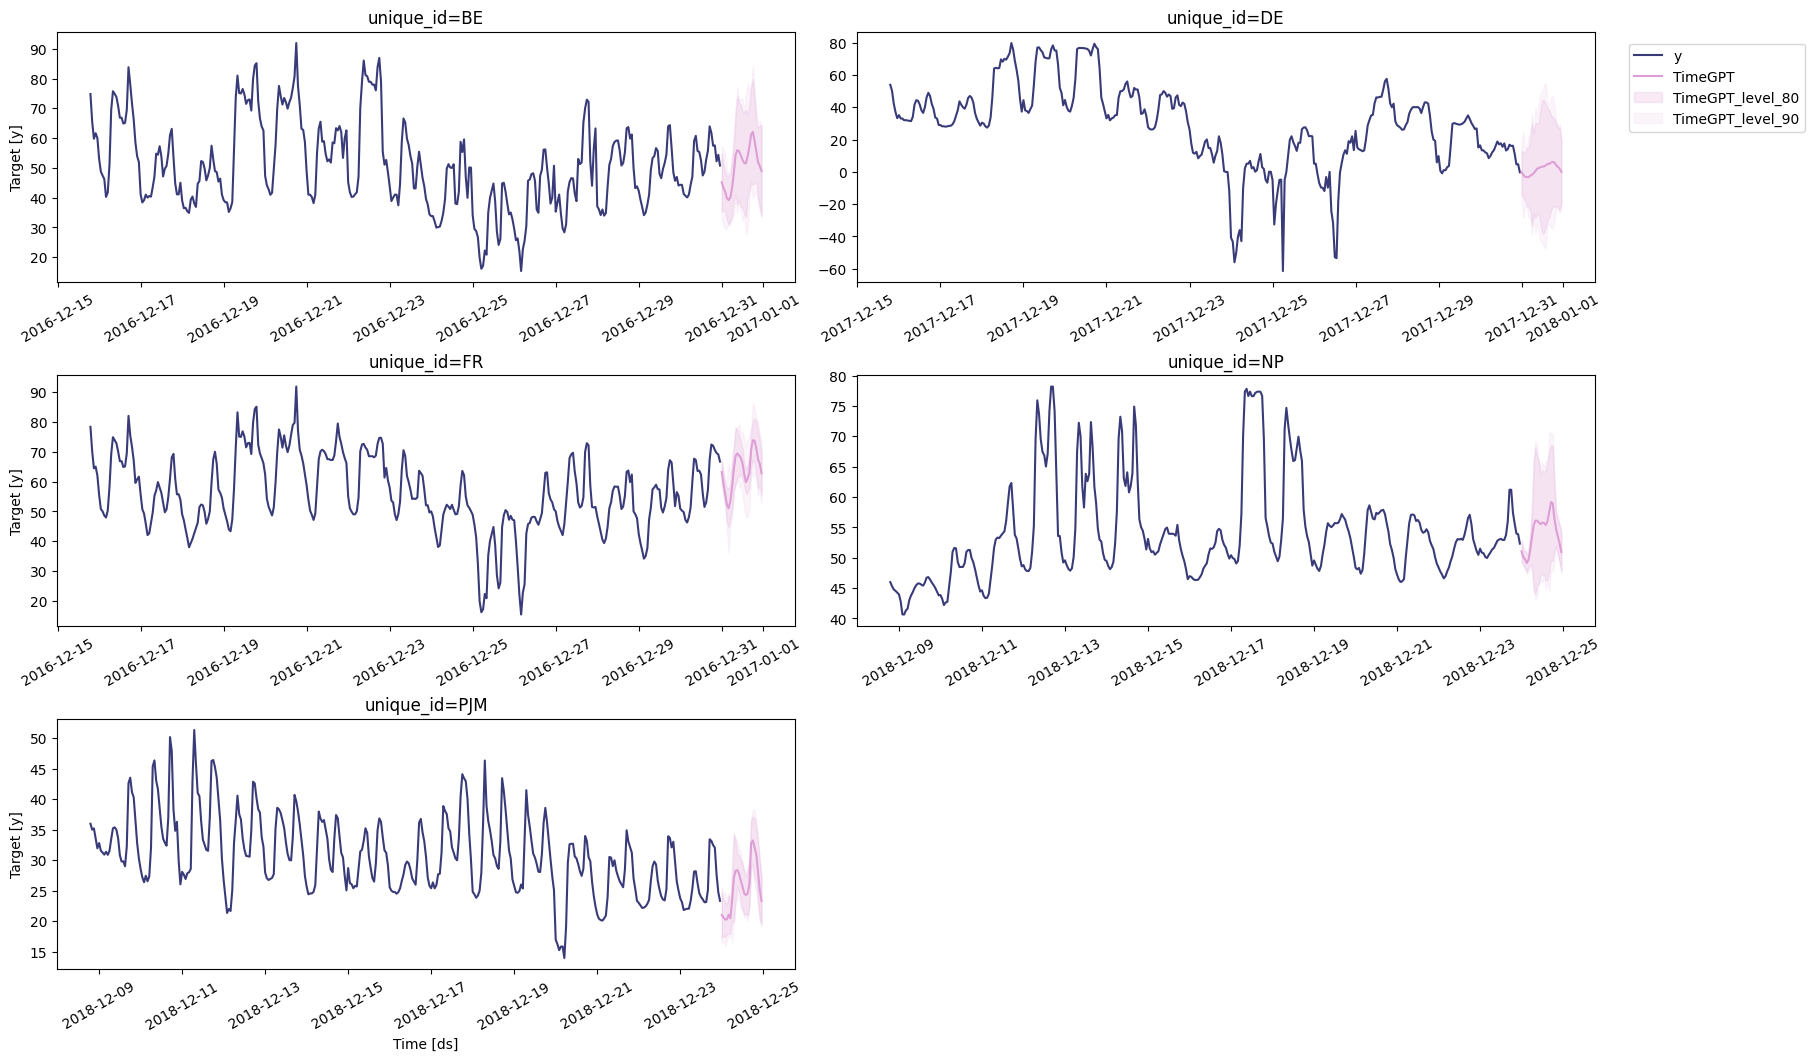

In [26]:
nixtla_client.plot(electricity, multivariate_forecast, max_insample_length=365, level=[80, 90])

### Single-Variable Long Horizon Bitcoin Price Forecasting

Since the bitcoin price data was collected on a daily time-frame, it is possible to use the time-gpt-1-long-horizon model for prediction of a couple days without increasing the uncertainty too much.

In [20]:
bitcoin = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/bitcoin_price_usd.csv')
print('Earliest date: ', bitcoin.Date.min())
print('Latest date: ', bitcoin.Date.max())
print(bitcoin.shape)
bitcoin.head()

Earliest date:  2020-01-01
Latest date:  2023-12-31
(1461, 2)


,Date,Close
0,2020-01-01,7200.174316
1,2020-01-02,6985.470215
2,2020-01-03,7344.884277
3,2020-01-04,7410.656738
4,2020-01-05,7411.317383


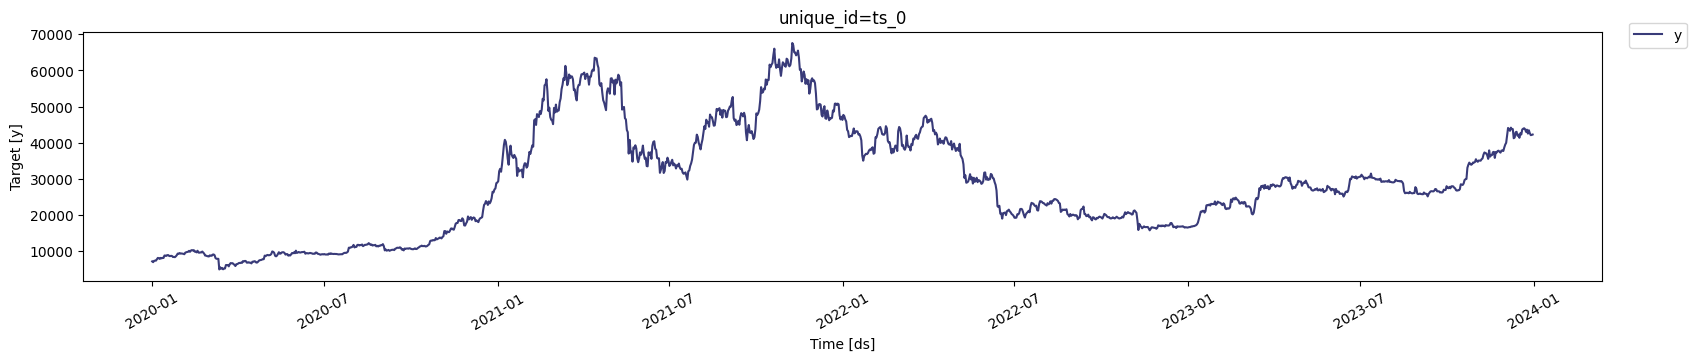

In [22]:
# nixtla client's plot method requires the feature names to be formatted
bitcoin.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
nixtla_client.plot(bitcoin)

In [32]:
bitcoin_longhorizon_forecast = nixtla_client.forecast(
    df=bitcoin,
    h=14, #horizon is set to 14 days, given daily recordings
    level=[90],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y'
)

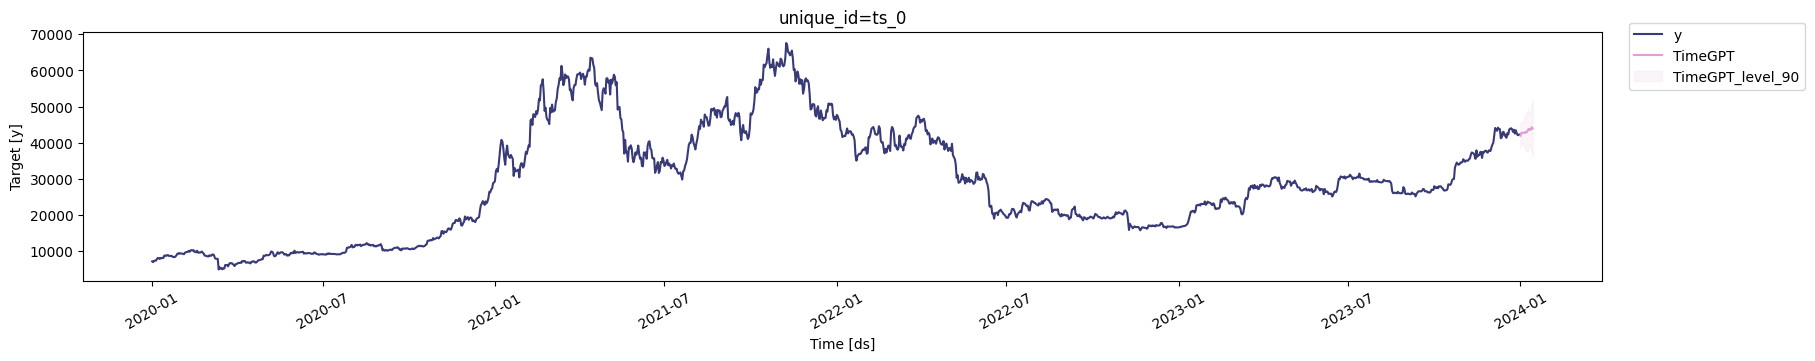

In [33]:
nixtla_client.plot(bitcoin, bitcoin_longhorizon_forecast, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

## Anomaly Detection

I'll be using the bitcoin single-variable data for anomaly detection to take a more direct look at the output of Time-GPT's anomaly detection method.

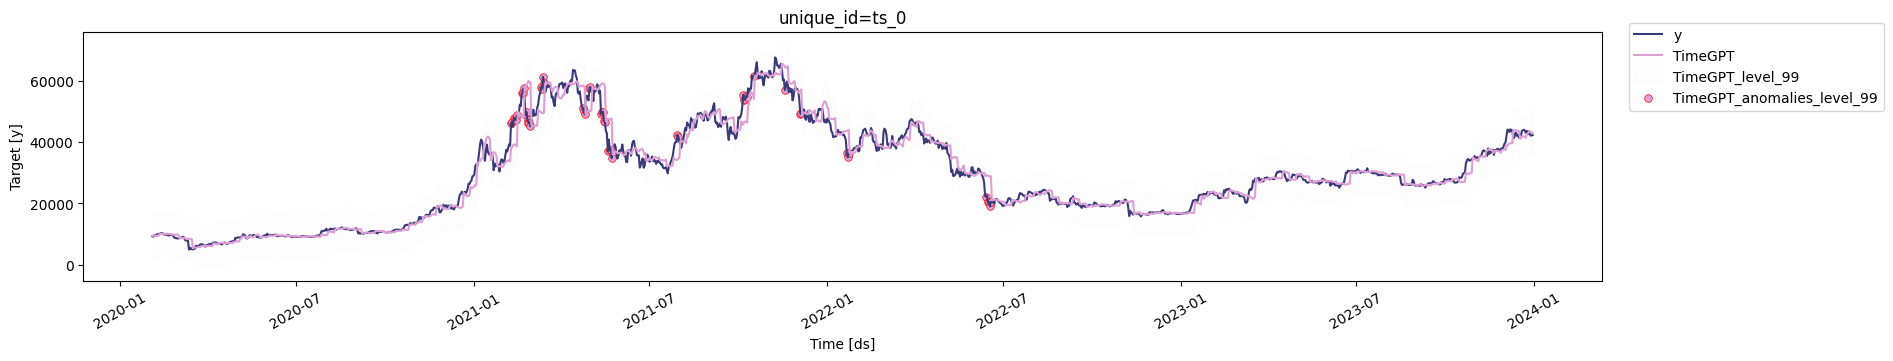

In [27]:
bitcoin_anomalies = nixtla_client.detect_anomalies(bitcoin)
nixtla_client.plot(bitcoin, bitcoin_anomalies, plot_anomalies=True)

## Forecasting with added Fine-tuning
Although the Nixtla API doesn't necessarily show you the fine-tuning steps or provide you with model weights, it allows you to fine-tune the model at prediction using the finetune_steps parameter in the forecast method.

In [37]:
bitcoin_forecast_finetuning = nixtla_client.forecast(df=electricity[['unique_id', 'ds', 'y']],
                                          h=24, # as the electricity data is recorded in hourly intervals this is 2 days
                                          finetune_steps = 50,
                                          level=[90, 95])

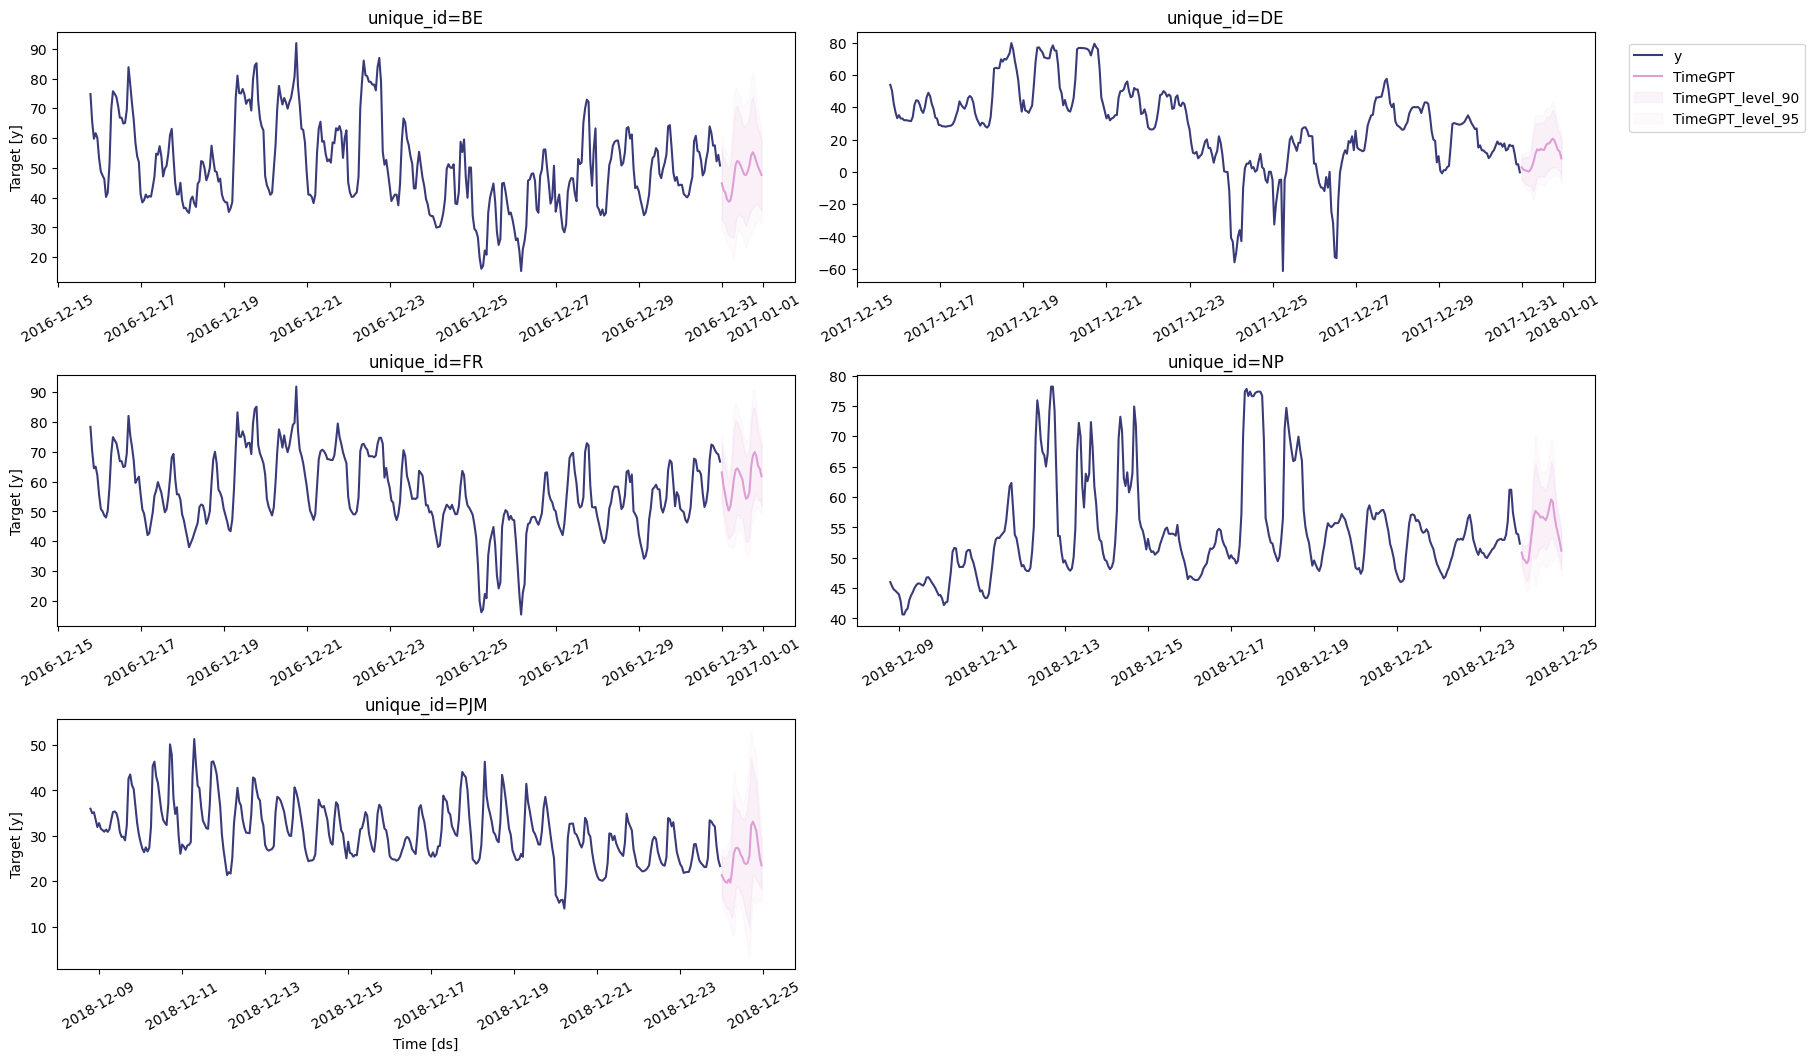

In [38]:
nixtla_client.plot(electricity, bitcoin_forecast_finetuning, max_insample_length=365, level=[90, 95])